In [4]:
pip install -U imbalanced-learn

     |████████████████████████████████| 174kB 3.2MB/s 
     |████████████████████████████████| 6.8MB 4.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [1]:
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM, LSTM, SimpleRNN, GRU, Bidirectional, RepeatVector
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout

from tensorflow.keras import regularizers

from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [2]:
import glob
import pandas as pd
import math
from imblearn.over_sampling import SMOTE, KMeansSMOTE
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
all_filenames = [i for i in glob.glob('/content/drive/My Drive/TrainingData/*.{}'.format('csv'))]

In [6]:
df_x, df_x_time, df_y, df_y_time = [], [], [], []
for f in all_filenames:
    if f.endswith('x.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_x.append(df)
    if f.endswith('x_time.csv'):
      df = pd.read_csv(f, header=None)
      df_x_time.append(df)
    if f.endswith('y.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_y.append(df)
    if f.endswith('y_time.csv'):
      df = pd.read_csv(f, header=None)
      df_y_time.append(df)
    
x = pd.concat(df_x, ignore_index=True)
x.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'subject', 'subject_ID']
x_time = pd.concat(df_x_time, ignore_index=True)
x_time.columns = ['x_time']
y = pd.concat(df_y, ignore_index=True)
y.columns = ['y', 'subject', 'subject_ID']
y_time = pd.concat(df_y_time, ignore_index=True)
y_time.columns = ['y_time']
x['time'] = x_time['x_time']
y['time'] = y_time['y_time']
y['time'] = [round(x+0.005,3) for x in y['time']]

In [ ]:
# x.drop(x[x['time'] == 0].index, inplace = True)

In [ ]:
# x.drop(x[x['time'] == 0.025].index, inplace = True)

In [7]:
full_df = pd.merge(x,y, on=['time','subject', 'subject_ID'], how='left')

In [8]:
full_df.head(20)

,x1,x2,x3,x4,x5,x6,subject,subject_ID,time,y
0,4.435275,8.196063,2.974488,0.014215,-0.039157,-0.016744,001,01,0.000,NaN
1,4.186920,8.344455,2.908057,0.005771,-0.004480,-0.003345,001,01,0.025,0.0
2,4.544637,8.408659,2.890000,0.007967,0.022412,0.001159,001,01,0.050,NaN
3,4.849308,8.411614,2.900692,0.027778,-0.010670,-0.014223,001,01,0.075,NaN
4,4.509190,8.118649,2.847298,0.021577,-0.045498,-0.021111,001,01,0.100,NaN
5,4.226515,8.273807,2.851742,0.012534,0.000445,-0.016830,001,01,0.125,0.0
6,4.532063,8.398341,2.856682,0.014484,0.028769,-0.011091,001,01,0.150,NaN
7,4.433669,8.294719,2.823521,0.016340,-0.029434,-0.008998,001,01,0.175,NaN
8,4.160676,8.260676,2.827568,0.011222,-0.016748,-0.006027,001,01,0.200,NaN
9,4.432763,8.272613,2.790050,-0.002715,0.023094,0.012222,001,01,0.225,0.0


In [8]:
full_df['y'] = full_df['y'].interpolate(method='nearest')

In [9]:
full_df.isna().sum()

x1            0
x2            0
x3            0
x4            0
x5            0
x6            0
subject       0
subject_ID    0
time          0
y             1
dtype: int64

In [10]:
full_df.dropna(inplace=True)

In [11]:
from numpy import array
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	end_flag = True
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			end_flag = False
			for j in range(i, len(sequences)):
				seq_x = sequences[j:, :-1]
				if seq_x.shape[0] < n_steps:
					# TODO add zero padding
					add_x = np.zeros((n_steps-seq_x.shape[0],6))
					# add_x = sequences[-(n_steps-seq_x.shape[0]):,:-1]
					seq_x = np.r_[seq_x, add_x]
					seq_y = sequences[j, -1]
				X.append(seq_x)
				y.append(seq_y)
			break
    # gather input and output parts of the pattern
		if (end_flag):
			seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
			X.append(seq_x)
			y.append(seq_y)
	return array(X), array(y)

In [12]:
final_X, final_y = list(), list()
for name, group in full_df.groupby(['subject', 'subject_ID']):
  df = group
  in_seq1 = df['x1'].to_numpy().reshape((len(df['x1']), 1))
  in_seq2 = df['x2'].to_numpy().reshape((len(df['x2']), 1))
  in_seq3 = df['x3'].to_numpy().reshape((len(df['x3']), 1))
  in_seq4 = df['x4'].to_numpy().reshape((len(df['x4']), 1))
  in_seq5 = df['x5'].to_numpy().reshape((len(df['x5']), 1))
  in_seq6 = df['x6'].to_numpy().reshape((len(df['x6']), 1))
  out_seq = df['y'].to_numpy().reshape((len(df['y']), 1))
  dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, out_seq))
  X, y = split_sequences(dataset, 40)
  final_X.extend(X)
  final_y.extend(y)
X = array(final_X)
y = array(final_y)

In [14]:
ind = np.argwhere(np.isnan(y)).flatten()

In [15]:
allrows = np.array(range(len(X)))
X_n = X[np.setdiff1d(allrows,ind)]

In [16]:
y = y[~np.isnan(y)]

In [17]:
X_n.shape

(1367083, 40, 6)

In [18]:
y = y.reshape(-1,1)

In [19]:
y.shape

(1367083, 1)

In [20]:
unique, counts = np.unique(y, return_counts=True)

In [21]:
print(unique)
print(counts)

[0. 1. 2. 3.]
[1017904   81578   60243  207358]


In [22]:
# Garbage collection to free memory
lst = [[full_df, df, final_X, final_y, X, df_x, df_x_time, df_y, df_y_time, df, in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, out_seq, dataset]]
del lst
full_df=pd.DataFrame()
df=pd.DataFrame()
final_X = []
final_y = []
X = []
df_x, df_x_time, df_y, df_y_time = [], [], [], []
df = []
in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, out_seq, dataset = [], [], [], [], [], [], [], []

In [84]:
# RNN Model with LSTM
model = Sequential()
# model.add(Embedding(130, 128, input_length=num_steps))
# model.add(Dropout(0.7))
model.add(LSTM(64, input_shape=(1,240), recurrent_activation='swish', return_sequences=True))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, recurrent_activation='swish', return_sequences=True)))
model.add(BatchNormalization())
model.add(LSTM(64, recurrent_activation='swish', return_sequences=True))
model.add(BatchNormalization())
model.add(Dense(64, activation='swish'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy', f1_m], sample_weight_mode="temporal")
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 64)             78080     
_________________________________________________________________
batch_normalization_14 (Batc (None, 1, 64)             256       
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 256)            197632    
_________________________________________________________________
batch_normalization_15 (Batc (None, 1, 256)            1024      
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 64)             82176     
_________________________________________________________________
batch_normalization_16 (Batc (None, 1, 64)             256       
_________________________________________________________________
dense_17 (Dense)             (None, 1, 64)            

In [85]:
model.output_shape

(None, 1, 4)

In [86]:
model.input_shape

(None, 1, 240)

In [24]:
# CNN model
model_CNN1 = Sequential()

#Adding the input layer and first hidden layer
model_CNN1.add(Dense(256, activation= 'swish', input_shape=(1,24)))
# model_CNN1.add(Dropout(0.25))
#Adding second hidden layer
model_CNN1.add(Dense(512, activation= 'swish'))
model_CNN1.add(BatchNormalization())
# model_CNN1.add(Dropout(0.25))
model_CNN1.add(Dense(256, activation= 'swish'))
model_CNN1.add(BatchNormalization())
model_CNN1.add(Dense(128, activation= 'swish'))
model_CNN1.add(BatchNormalization())
model_CNN1.add(Dense(64, activation= 'swish'))
model_CNN1.add(BatchNormalization())
#Adding the Output Layer
model_CNN1.add(Dense(4, activation='softmax')) 
#Compiling
model_CNN1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_m, 'categorical_accuracy'])
model_CNN1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 256)            6400      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 512)            131584    
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 512)            2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 256)            131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 256)            1024      
_________________________________________________________________
dense_3 (Dense)              (None, 1, 128)            32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 128)            5

In [68]:
# CNN model
model_CNN = Sequential()

#Adding the input layer and first hidden layer
model_CNN.add(Dense(256, activation= 'swish', input_shape=(1,240)))
#Adding second hidden layer
model_CNN.add(Dense(512, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(512, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(256, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(128, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(64, activation= 'swish'))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(32, activation= 'swish'))
model_CNN.add(BatchNormalization())
#Adding the Output Layer
model_CNN.add(Dense(4, activation='softmax')) 
#Compiling
model_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', f1_m], sample_weight_mode="temporal")
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1, 256)            61696     
_________________________________________________________________
dense_8 (Dense)              (None, 1, 512)            131584    
_________________________________________________________________
batch_normalization_5 (Batch (None, 1, 512)            2048      
_________________________________________________________________
dense_9 (Dense)              (None, 1, 512)            262656    
_________________________________________________________________
batch_normalization_6 (Batch (None, 1, 512)            2048      
_________________________________________________________________
dense_10 (Dense)             (None, 1, 256)            131328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 1, 256)           

In [24]:
model_CNN.input_shape

(None, 1, 240)

In [25]:
model_CNN.output_shape

(None, 1, 4)

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_n, y, test_size=0.3, random_state=177)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(full_df[['x1','x2','x3', 'x4', 'x5', 'x6']], full_df['y'], test_size=0.3, random_state=177)

In [27]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,240))
X_test = scaler.transform(X_test.reshape(-1,240))

In [28]:
# Clearing out memory
lst = [[X_n, y, x, x_time]]
del lst
X_n = []
y = []
x = []
x_time = []

In [31]:
model_CNN.input_shape

(None, 1, 240)

In [32]:
model_CNN.output_shape

(None, 1, 4)

In [29]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)

[0. 1. 2. 3.]
[712382  57263  42221 145092]


In [30]:
# Over Sampling Classes 1 and 2 using kmeansSMOTE
oversample = KMeansSMOTE(sampling_strategy={1:100000, 2:100000}, cluster_balance_threshold=0.02, k_neighbors=3)

In [31]:
X_train = X_train.reshape(-1,240)

In [32]:
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [33]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)

[0. 1. 2. 3.]
[712382 100005 100003 145092]


In [ ]:
len(y_train)

1257854

In [34]:
# Ading class weight parameter in CNN models
class_weights = np.zeros((len(y_train), 4))
class_weights[:, 0] += 1
class_weights[:, 1] += 50
class_weights[:, 2] += 45
class_weights[:, 3] += 10

In [ ]:
class_weights = class_weights.reshape(-1,1,4)

In [ ]:
class_weights.shape

(1058024, 4)

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)

In [ ]:
print(unique)
print(counts)

[0. 1.]
[3772014 1257338]


In [35]:
# Reshape inputs according to input shape
X_train = X_train.reshape(-1,1,240)
X_test = X_test.reshape(-1,1,240)

In [36]:
X_train.shape

(1057482, 1, 240)

In [41]:
y_train.shape

(1057482, 1, 4)

In [39]:
model_CNN.output_shape

(None, 1, 4)

In [40]:
# Reshape according to model output size
y_train = to_categorical(y_train).reshape(-1,1,4)
y_test = to_categorical(y_test).reshape(-1,1,4)

In [ ]:
y_train = y_train.reshape(-1,1,4)
y_test = y_test.reshape(-1,1,4)

In [69]:
# Saving best model each time
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('/content/drive/My Drive/FinalRNNextralayer711{epoch:08d}.h5', save_best_only=True) 

In [ ]:
RNN_ts40_weight = model.fit(X_train, y_train, epochs = 30, validation_data= (X_test, y_test), callbacks=[checkpoint], batch_size=400, sample_weight=class_weights)

Epoch 1/30
2644/2644 [==============================] - 107s 40ms/step - loss: 25.0129 - categorical_accuracy: 0.6750 - f1_m: 0.6592 - val_loss: 0.7814 - val_categorical_accuracy: 0.7391 - val_f1_m: 0.7329
Epoch 2/30
2644/2644 [==============================] - 101s 38ms/step - loss: 20.6972 - categorical_accuracy: 0.7198 - f1_m: 0.7142 - val_loss: 0.7201 - val_categorical_accuracy: 0.7537 - val_f1_m: 0.7492
Epoch 3/30
2644/2644 [==============================] - 103s 39ms/step - loss: 19.0925 - categorical_accuracy: 0.7417 - f1_m: 0.7377 - val_loss: 0.6925 - val_categorical_accuracy: 0.7613 - val_f1_m: 0.7573
Epoch 4/30
2644/2644 [==============================] - 102s 39ms/step - loss: 18.1030 - categorical_accuracy: 0.7558 - f1_m: 0.7524 - val_loss: 0.6626 - val_categorical_accuracy: 0.7728 - val_f1_m: 0.7704
Epoch 5/30
2644/2644 [==============================] - 102s 39ms/step - loss: 17.3884 - categorical_accuracy: 0.7657 - f1_m: 0.7630 - val_loss: 0.6533 - val_categorical_accura

In [70]:
CNN_40ts_extra = model_CNN.fit(X_train, y_train, epochs = 30, validation_data= (X_test, y_test), callbacks=[checkpoint], batch_size=400, sample_weight=class_weights)

Epoch 1/30
2644/2644 [==============================] - 149s 57ms/step - loss: 20.4309 - categorical_accuracy: 0.7225 - f1_m: 0.7040 - val_loss: 0.6691 - val_categorical_accuracy: 0.7684 - val_f1_m: 0.7633
Epoch 2/30
2644/2644 [==============================] - 150s 57ms/step - loss: 16.6816 - categorical_accuracy: 0.7726 - f1_m: 0.7699 - val_loss: 0.6052 - val_categorical_accuracy: 0.7865 - val_f1_m: 0.7845
Epoch 3/30
2644/2644 [==============================] - 152s 57ms/step - loss: 14.8242 - categorical_accuracy: 0.7971 - f1_m: 0.7953 - val_loss: 0.5768 - val_categorical_accuracy: 0.7952 - val_f1_m: 0.7938
Epoch 4/30
2644/2644 [==============================] - 153s 58ms/step - loss: 13.5750 - categorical_accuracy: 0.8129 - f1_m: 0.8116 - val_loss: 0.5490 - val_categorical_accuracy: 0.8057 - val_f1_m: 0.8047
Epoch 5/30
2644/2644 [==============================] - 151s 57ms/step - loss: 12.6307 - categorical_accuracy: 0.8244 - f1_m: 0.8232 - val_loss: 0.5412 - val_categorical_accura

In [43]:
CNN_40ts_zp = model_CNN.fit(X_train, y_train, epochs = 30, validation_data= (X_test, y_test), callbacks=[checkpoint], batch_size=400, sample_weight=class_weights)

Epoch 1/30
2644/2644 [==============================] - 92s 35ms/step - loss: 20.4821 - categorical_accuracy: 0.7227 - f1_m: 0.7048 - val_loss: 0.6647 - val_categorical_accuracy: 0.7703 - val_f1_m: 0.7662
Epoch 2/30
2644/2644 [==============================] - 93s 35ms/step - loss: 16.8113 - categorical_accuracy: 0.7720 - f1_m: 0.7690 - val_loss: 0.6191 - val_categorical_accuracy: 0.7822 - val_f1_m: 0.7795
Epoch 3/30
2644/2644 [==============================] - 92s 35ms/step - loss: 15.1567 - categorical_accuracy: 0.7933 - f1_m: 0.7913 - val_loss: 0.5895 - val_categorical_accuracy: 0.7899 - val_f1_m: 0.7881
Epoch 4/30
2644/2644 [==============================] - 93s 35ms/step - loss: 14.0825 - categorical_accuracy: 0.8072 - f1_m: 0.8056 - val_loss: 0.5719 - val_categorical_accuracy: 0.7974 - val_f1_m: 0.7959
Epoch 5/30
2644/2644 [==============================] - 92s 35ms/step - loss: 13.2983 - categorical_accuracy: 0.8172 - f1_m: 0.8159 - val_loss: 0.5621 - val_categorical_accuracy: 0

In [ ]:
model_CNN.output_shape

(None, 1, 4)

In [ ]:
# Load model if needed
from keras.models import load_model
CNN_model = load_model('/content/drive/My Drive/CNNdnkmfull41100000023.h5', custom_objects={'f1_m': f1_m})

In [45]:
# Function to split test data into proper inputs
def split_test_sequences(sequences, n_steps):
  X = list()
  end_flag = True 
  for i in range(0,len(sequences)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(sequences):
      end_flag = False
      for j in range(i, len(sequences)):  
        seq_x = sequences[j:, :]
        if seq_x.shape[0] < n_steps:
          add_x = np.zeros((n_steps-seq_x.shape[0],6))
          seq_x = np.r_[seq_x, add_x]
        X.append(seq_x)
      break
    # gather input and output parts of the pattern
    if (end_flag):
      seq_x = sequences[i:end_ix, :]
      X.append(seq_x)
  return array(X)

In [ ]:
model_CNN.input_shape

(None, 1, 60)

In [75]:
# Code block to transform the test data into inputs and join with y_time to get the prediction at that specific y_time
test_filenames = [i for i in glob.glob('/content/drive/My Drive/TestData/*.{}'.format('csv'))]
df_x, df_x_time, df_y_time = [], [], []
for f in test_filenames:
  if '009' in f:
    if f.endswith('x.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_x.append(df)
    if f.endswith('x_time.csv'):
      df = pd.read_csv(f, header=None)
      df_x_time.append(df)
    if f.endswith('y_time.csv'):
      df = pd.read_csv(f, header=None)
      df['subject'] = f.split('/')[-1].split('_')[1]
      df['subject_ID'] = f.split('/')[-1].split('_')[2]
      df_y_time.append(df)
    
test_x = pd.concat(df_x, ignore_index=True)
test_x.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'subject', 'subject_ID']
test_x_time = pd.concat(df_x_time, ignore_index=True)
test_x_time.columns = ['x_time']
test_y_time = pd.concat(df_y_time, ignore_index=True)
test_y_time.columns = ['time', 'subject', 'subject_ID']
test_x['time'] = test_x_time['x_time']
test_y_time['time'] = [round(x + 0.005,3) for x in test_y_time['time']]
final_test = pd.merge(test_x, test_y_time, on=['time', 'subject', 'subject_ID'], how='left')
in_seq1 = final_test['x1'].to_numpy().reshape((len(final_test['x1']), 1))
in_seq2 = final_test['x2'].to_numpy().reshape((len(final_test['x2']), 1))
in_seq3 = final_test['x3'].to_numpy().reshape((len(final_test['x3']), 1))
in_seq4 = final_test['x4'].to_numpy().reshape((len(final_test['x4']), 1))
in_seq5 = final_test['x5'].to_numpy().reshape((len(final_test['x5']), 1))
in_seq6 = final_test['x6'].to_numpy().reshape((len(final_test['x6']), 1))
dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6))
test_x = split_test_sequences(dataset, 40)
# scaler = StandardScaler()
test_x = scaler.transform(test_x.reshape(-1,240))
test = test_x.reshape(-1,1,240)
y_pred = model_CNN.predict(test)
y_pred = np.argmax(y_pred.reshape(-1,4), axis=1)
final_test['y_pred'] = y_pred
pred = pd.merge(final_test, test_y_time, on=['time', 'subject', 'subject_ID'], how='inner')['y_pred']
pred.to_csv("subject_009_01__y_prediction.csv", index=False, header=False)
# np.savetxt("subject_009_01__y_prediction.csv", y_pred, delimiter=",")

In [57]:
pred.shape

(11330,)

In [76]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss graphs
def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

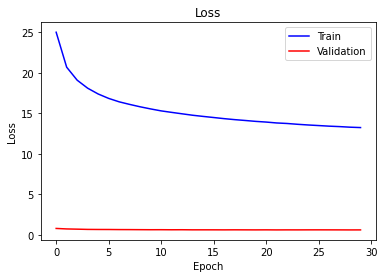

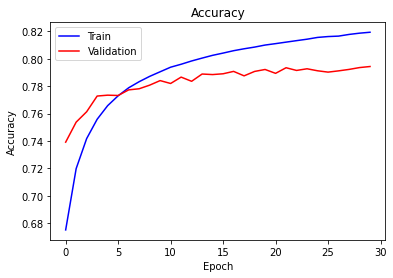

In [88]:
plot_history(RNN_ts40_weight)

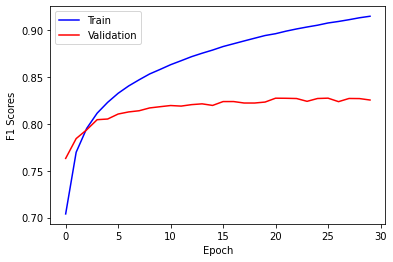

In [79]:
# Plotting f1 metric
plt.plot(CNN_40ts_extra.history['f1_m'], color='blue', label='train')
plt.plot(CNN_40ts_extra.history['val_f1_m'], color='red', label='test')
plt.ylabel('F1 Scores')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

In [71]:
# Classification report for the model on the test data we split using test_train_split
from sklearn.metrics import classification_report
y_p = model_CNN.predict(X_test)
y_p = np.argmax(y_p.reshape(-1,4), axis=1)
y_test_n = np.argmax(y_test.reshape(-1,4), axis=1)
print(classification_report(y_test_n, y_p))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89    305522
           1       0.62      0.55      0.58     24315
           2       0.58      0.44      0.50     18022
           3       0.71      0.61      0.66     62266

    accuracy                           0.83    410125
   macro avg       0.69      0.63      0.66    410125
weighted avg       0.82      0.83      0.82    410125



In [44]:
from sklearn.metrics import classification_report
y_p = model_CNN.predict(X_test)
y_p = np.argmax(y_p.reshape(-1,4), axis=1)
y_test_n = np.argmax(y_test.reshape(-1,4), axis=1)
print(classification_report(y_test_n, y_p))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89    305522
           1       0.64      0.47      0.54     24315
           2       0.56      0.38      0.46     18022
           3       0.70      0.56      0.62     62266

    accuracy                           0.82    410125
   macro avg       0.69      0.58      0.63    410125
weighted avg       0.80      0.82      0.81    410125



In [ ]:
from sklearn.metrics import classification_report
y_p = model_CNN.predict(X_test)
y_p = np.argmax(y_p.reshape(-1,4), axis=1)
y_test_n = np.argmax(y_test.reshape(-1,4), axis=1)
print(classification_report(y_test_n, y_p))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87    305160
           1       0.58      0.42      0.48     24476
           2       0.49      0.36      0.42     18343
           3       0.64      0.54      0.59     62146

    accuracy                           0.80    410125
   macro avg       0.64      0.56      0.59    410125
weighted avg       0.78      0.80      0.79    410125



In [ ]:
y_test_n = np.argmax(y_test.reshape(-1,4), axis=1)
print(classification_report(y_test_n, y_p))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85    304469
           1       0.38      0.29      0.33     27394
           2       0.35      0.20      0.25     15429
           3       0.62      0.27      0.38     62833

    accuracy                           0.75    410125
   macro avg       0.54      0.42      0.45    410125
weighted avg       0.72      0.75      0.72    410125



In [89]:
from sklearn.metrics import classification_report
y_p = model.predict(X_test)
y_p = np.argmax(y_p.reshape(-1,4), axis=1)
y_test_n = np.argmax(y_test.reshape(-1,4), axis=1)
print(classification_report(y_test_n, y_p))

              precision    recall  f1-score   support

           0       0.82      0.94      0.87    305522
           1       0.56      0.35      0.43     24315
           2       0.54      0.26      0.35     18022
           3       0.71      0.42      0.53     62266

    accuracy                           0.79    410125
   macro avg       0.66      0.49      0.55    410125
weighted avg       0.78      0.79      0.77    410125

